In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

import warnings
warnings.filterwarnings("ignore")

In [2]:
df0 = pd.read_csv('./datasets/stock-tesla.csv', parse_dates=['Date'])
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1692 non-null   datetime64[ns]
 1   Open       1692 non-null   float64       
 2   High       1692 non-null   float64       
 3   Low        1692 non-null   float64       
 4   Close      1692 non-null   float64       
 5   Volume     1692 non-null   int64         
 6   Adj Close  1692 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 92.7 KB


In [3]:
df0.columns = ['date', 'open', 'high', 'low', 'close', 'vol', 'adj_close']
df0

,date,open,high,low,close,vol,adj_close
0,2010-06-29,19.000000,25.000000,17.540001,23.889999,18766300,23.889999
1,2010-06-30,25.790001,30.420000,23.299999,23.830000,17187100,23.830000
2,2010-07-01,25.000000,25.920000,20.270000,21.959999,8218800,21.959999
3,2010-07-02,23.000000,23.100000,18.709999,19.200001,5139800,19.200001
4,2010-07-06,20.000000,20.000000,15.830000,16.110001,6866900,16.110001
...,...,...,...,...,...,...,...
1687,2017-03-13,244.820007,246.850006,242.779999,246.169998,3010700,246.169998
1688,2017-03-14,246.110001,258.119995,246.020004,258.000000,7575500,258.000000
1689,2017-03-15,257.000000,261.000000,254.270004,255.729996,4816600,255.729996
1690,2017-03-16,262.399994,265.750000,259.059998,262.049988,7100400,262.049988


In [4]:
df0.date.dt.year.value_counts()

2016    252
2015    252
2014    252
2013    252
2011    252
2012    250
2010    130
2017     52
Name: date, dtype: int64

In [5]:
# Train
130+252+250+252+252+252

1388

In [6]:
# A new dataframe with only train and valid
df = df0.copy()
df

,date,open,high,low,close,vol,adj_close
0,2010-06-29,19.000000,25.000000,17.540001,23.889999,18766300,23.889999
1,2010-06-30,25.790001,30.420000,23.299999,23.830000,17187100,23.830000
2,2010-07-01,25.000000,25.920000,20.270000,21.959999,8218800,21.959999
3,2010-07-02,23.000000,23.100000,18.709999,19.200001,5139800,19.200001
4,2010-07-06,20.000000,20.000000,15.830000,16.110001,6866900,16.110001
...,...,...,...,...,...,...,...
1687,2017-03-13,244.820007,246.850006,242.779999,246.169998,3010700,246.169998
1688,2017-03-14,246.110001,258.119995,246.020004,258.000000,7575500,258.000000
1689,2017-03-15,257.000000,261.000000,254.270004,255.729996,4816600,255.729996
1690,2017-03-16,262.399994,265.750000,259.059998,262.049988,7100400,262.049988


In [7]:
df[:1388].tail()

,date,open,high,low,close,vol,adj_close
1383,2015-12-24,230.559998,231.880005,228.279999,230.570007,708000,230.570007
1384,2015-12-28,231.490005,231.979996,225.539993,228.949997,1901300,228.949997
1385,2015-12-29,230.059998,237.720001,229.550003,237.190002,2406300,237.190002
1386,2015-12-30,236.600006,243.630005,235.669998,238.089996,3697900,238.089996
1387,2015-12-31,238.509995,243.449997,238.369995,240.009995,2683200,240.009995


In [8]:
df[1388:].head()

,date,open,high,low,close,vol,adj_close
1388,2016-01-04,230.720001,231.380005,219.000000,223.410004,6827100,223.410004
1389,2016-01-05,226.360001,226.889999,220.000000,223.429993,3186800,223.429993
1390,2016-01-06,220.000000,220.050003,215.979996,219.039993,3779100,219.039993
1391,2016-01-07,214.190002,218.440002,213.669998,215.649994,3554300,215.649994
1392,2016-01-08,217.860001,220.440002,210.770004,211.000000,3628100,211.000000


In [9]:
# Sort index
data = df.sort_index(ascending=True, axis=0)

# Make a new dataframe with `date` and `close` columns
new_data = pd.DataFrame(index=range(0,len(df)),columns=['date', 'close'])
for i in range(0,len(data)):
    new_data['date'][i] = data['date'][i]
    new_data['close'][i] = data['close'][i]

In [10]:
# Make the `date` column as index
new_data.index = new_data.date
new_data.drop('date', axis=1, inplace=True)
new_data

,close
date,
2010-06-29,23.89
2010-06-30,23.83
2010-07-01,21.96
2010-07-02,19.2
2010-07-06,16.11
...,...
2017-03-13,246.17
2017-03-14,258
2017-03-15,255.73


In [11]:
dataset = new_data.values
dataset

array([[23.889999],
       [23.83],
       [21.959999],
       ...,
       [255.729996],
       [262.049988],
       [261.5]], dtype=object)

In [12]:
train = dataset[0:1388,:]
valid = dataset[1388:,:]
len(train), len(valid)

(1388, 304)

In [13]:
# Convert dataset into X_train and y_train

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

X_train, y_train = [], []

# Looking back 60 days (?? still need to learn more about this block of code)
for i in range(60, len(train)):
    X_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [14]:
# Instantiate and fit a model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=2)

1328/1328 - 18s - loss: 0.0036


In [15]:
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [16]:
inputs.shape

(364, 1)

In [17]:
inputs[300-60:300,0]

array([0.69878624, 0.70093248, 0.70540996, 0.70918439, 0.71488306,
       0.70311572, 0.70481793, 0.6842066 , 0.69652898, 0.73231198,
       0.72383806, 0.71292185, 0.68531673, 0.66907192, 0.6851317 ,
       0.68198638, 0.68720393, 0.68250444, 0.66870185, 0.65926584,
       0.67828597, 0.69478979, 0.67828597, 0.68194934, 0.69182944,
       0.69027527, 0.68990526, 0.69645496, 0.68150531, 0.67321636,
       0.64753548, 0.63728537, 0.6350651 , 0.6466844 , 0.65649053,
       0.66289223, 0.64483419, 0.62740527, 0.63928357, 0.61297362,
       0.62155861, 0.62215063, 0.63965363, 0.62618413, 0.62433392,
       0.64894165, 0.65623147, 0.66921991, 0.66725869, 0.64302102,
       0.6423919 , 0.61456483, 0.61304764, 0.63277086, 0.62925548,
       0.65626846, 0.6530861 , 0.65267905, 0.65360416, 0.67477053])

In [18]:
new_data[len(new_data) - len(valid) - 60:]

,close
date,
2015-10-07,231.96
2015-10-08,226.72
2015-10-09,220.69
2015-10-12,215.58
2015-10-13,219.25
...,...
2017-03-13,246.17
2017-03-14,258
2017-03-15,255.73


In [19]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

In [20]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [21]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

12.928522627673777

In [22]:
train = new_data[:1388]
valid = new_data[1388:]
valid['predictions'] = closing_price

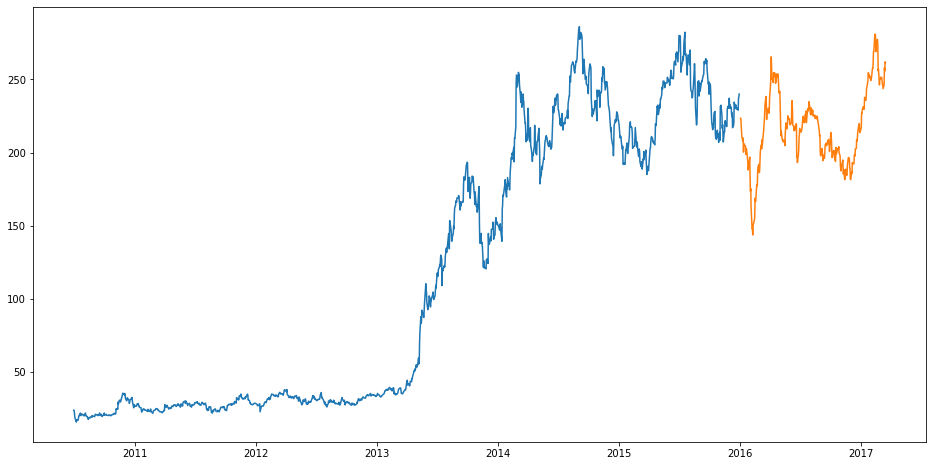

In [23]:
plt.figure(figsize=(16,8))
plt.plot(train['close'])
plt.plot(valid[['close']]);

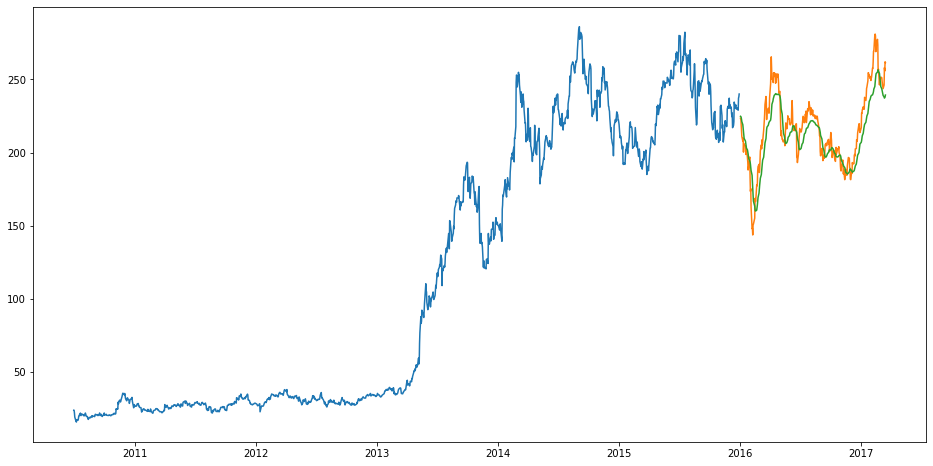

In [24]:
plt.figure(figsize=(16,8))
plt.plot(train['close'])
plt.plot(valid[['close', 'predictions']]);

**Looking back 30 days**

end-to-end code

1358/1358 - 10s - loss: 0.0038


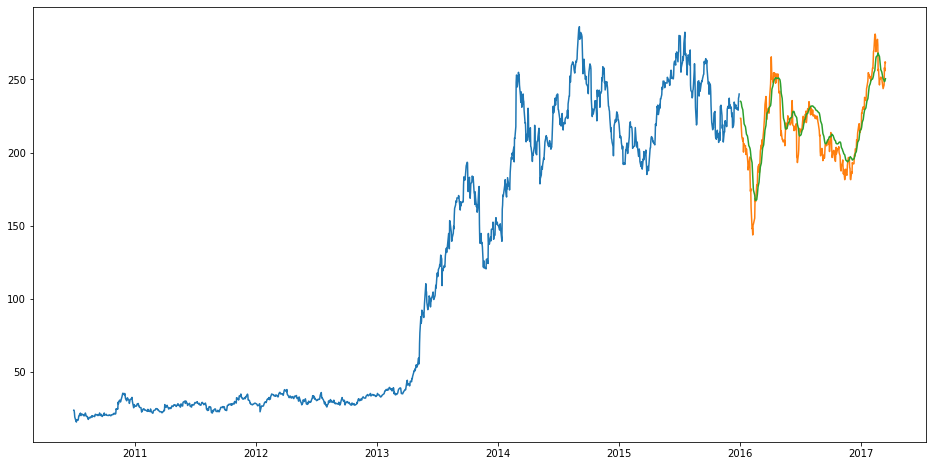

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

import warnings
warnings.filterwarnings("ignore")

# Set a random seed
np.random.seed(42)

# Load the dataset
df0 = pd.read_csv('./datasets/stock-tesla.csv', parse_dates=['Date'])
df0.columns = ['date', 'open', 'high', 'low', 'close', 'vol', 'adj_close']

# Make a copy
df = df0.copy()

# Sort and make a new dataframe consists of date and close
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['date', 'close'])
for i in range(0,len(data)):
    new_data['date'][i] = data['date'][i]
    new_data['close'][i] = data['close'][i]

# Make date as index and drop the existing date column
new_data.index = new_data.date
new_data.drop('date', axis=1, inplace=True)

# Grab the values
dataset = new_data.values

# Split into train and valid
training = dataset[0:1388,:]
validation = dataset[1388:,:]

# Scale the dataset using minmaxscaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(training)

# Make X_train and y_train
X_train, y_train = [], []
for i in range(30, len(training)):
    X_train.append(scaled_data[i-30:i,0])
    y_train.append(scaled_data[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

# Instantiate and fit a model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=2)

# Prepare the X_test
inputs = new_data[len(new_data) - len(validation) - 30:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(30,inputs.shape[0]):
    X_test.append(inputs[i-30:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

# Make predictions
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

# Evaluate using RMS
rms = np.sqrt(np.mean(np.power((validation-closing_price),2)))

# Visualize
train = new_data[:1388]
valid = new_data[1388:]
valid['predictions'] = closing_price

plt.figure(figsize=(16,8))
plt.plot(train['close'])
plt.plot(valid[['close', 'predictions']]);

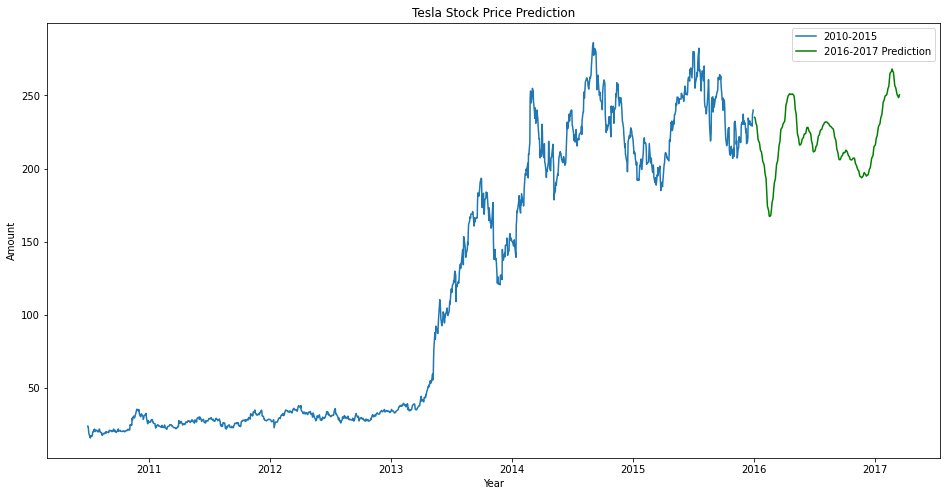

In [2]:
plt.figure(figsize=(16,8))
plt.plot(train['close'])
plt.plot(valid[['predictions']], c='green')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Year')
plt.ylabel('Amount')
plt.legend(('2010-2015', '2016-2017 Prediction'));

In [3]:
train

,close
date,
2010-06-29,23.89
2010-06-30,23.83
2010-07-01,21.96
2010-07-02,19.2
2010-07-06,16.11
...,...
2015-12-24,230.57
2015-12-28,228.95
2015-12-29,237.19


In [4]:
valid

,close,predictions
date,,
2016-01-04,223.41,240.417114
2016-01-05,223.43,240.383530
2016-01-06,219.04,239.805588
2016-01-07,215.65,238.630890
2016-01-08,211,236.984863
...,...,...
2017-03-13,246.17,255.449631
2017-03-14,258,254.589569
2017-03-15,255.73,254.747116


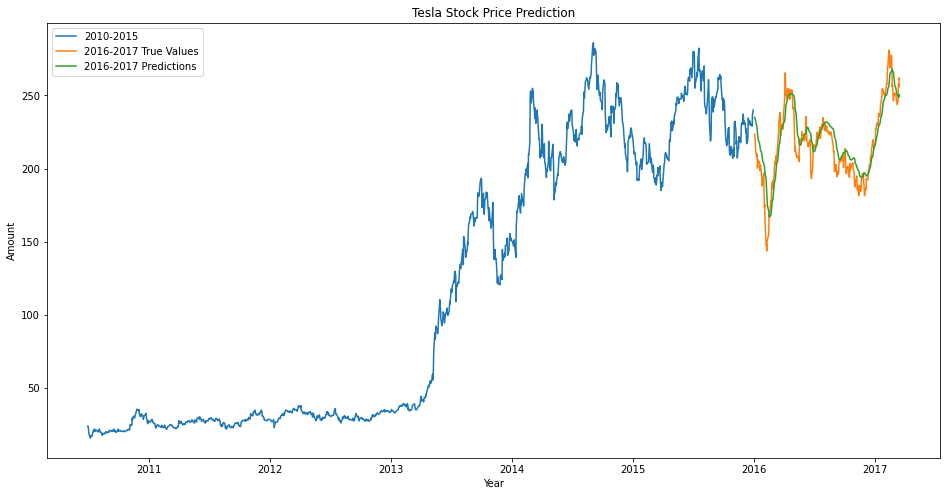

In [11]:
plt.figure(figsize=(16,8))
plt.plot(train['close'])
plt.plot(valid[['close', 'predictions']])
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Year')
plt.ylabel('Amount')
plt.legend(('2010-2015', '2016-2017 True Values', '2016-2017 Predictions'));